In [1]:
import logging
import os
import shutil
import sys
import tempfile
import glob

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import NiftiDataset, create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandSpatialCropd, RandAffined, Spacingd, Orientationd, ToTensord
from monai.visualize import plot_2d_or_3d_image

from torch import nn
monai.config.print_config()

from typing import Optional, Union

import warnings

from monai.networks import one_hot
from monai.utils import MetricReduction

MONAI version: 0.1.0+626.g63eec3a.dirty
Python version: 3.7.4 (default, Jul 18 2019, 19:34:02)  [GCC 5.4.0]
Numpy version: 1.18.1
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.14.2
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# Supervised learning data for training and validation
data_dir = '/home/marafath/scratch/eu_challenge/synthetic_data'
train_images = sorted(glob.glob(os.path.join(data_dir, '*_vol.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_dir, '*_labels.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]

In [24]:
# Fold
fold = 4

if fold == 1:
    val_files = data_dicts[72:96]
elif fold == 2:
    val_files = data_dicts[48:72]
elif fold == 3:
    val_files = data_dicts[24:48]
elif fold == 4:
    val_files = data_dicts[0:24]

In [25]:
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    ToTensord(keys=['image', 'label'])
])

In [26]:
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(
        val_ds, 
        batch_size=1, 
        num_workers=4, 
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available()
)

In [1]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=7,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

NameError: name 'torch' is not defined

In [28]:
model.load_state_dict(torch.load('/home/marafath/scratch/saved_models/eu_best_f{}.pth'.format(fold)))

<All keys matched successfully>

In [22]:
dice_metric = DiceMetric(include_background=False, to_onehot_y=True, mutually_exclusive=True, reduction="mean")

In [ ]:
model.eval()
with torch.no_grad():
    metric_sum = 0.0
    metric_count = 0
    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        # define sliding window size and batch size for windows inference
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        value = dice_metric(y_pred=val_outputs, y=val_labels)
        metric_count += len(value)
        metric_sum += value.item() * len(value)
    metric = metric_sum / metric_count
    print("evaluation metric:", metric)

image shape: (225, 231, 235), label shape: (225, 231, 235)


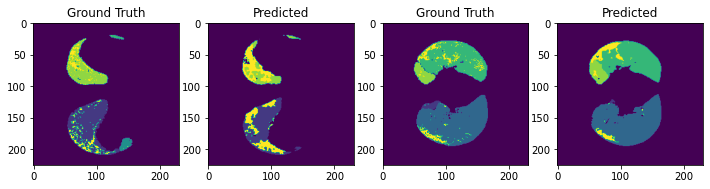

image shape: (257, 257, 258), label shape: (257, 257, 258)


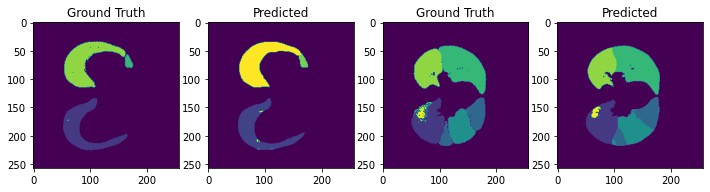

image shape: (234, 234, 200), label shape: (234, 234, 200)


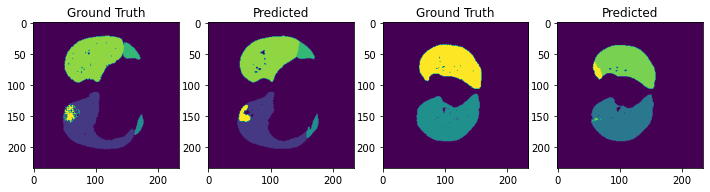

image shape: (289, 289, 203), label shape: (289, 289, 203)


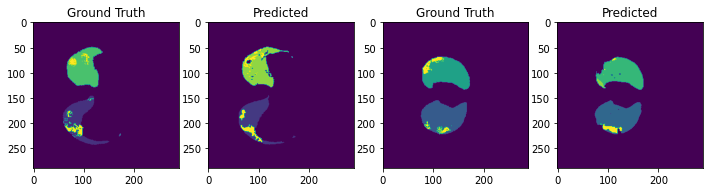

image shape: (216, 216, 224), label shape: (216, 216, 224)


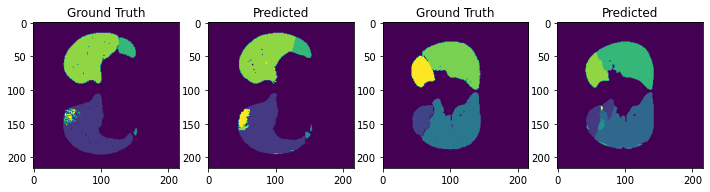

image shape: (244, 244, 193), label shape: (244, 244, 193)


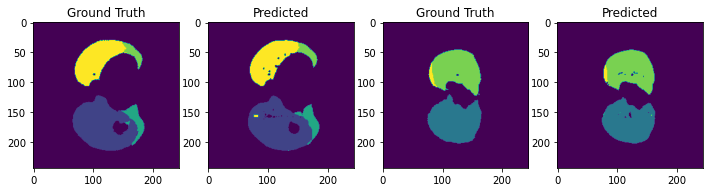

image shape: (219, 219, 222), label shape: (219, 219, 222)


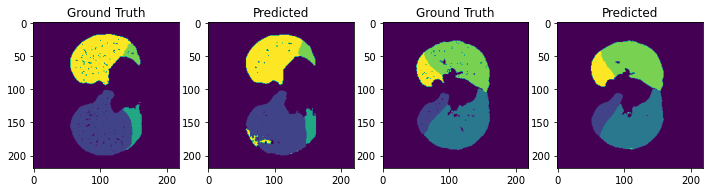

image shape: (252, 252, 200), label shape: (252, 252, 200)


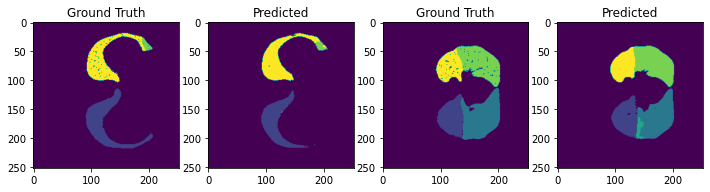

image shape: (232, 230, 196), label shape: (232, 230, 196)


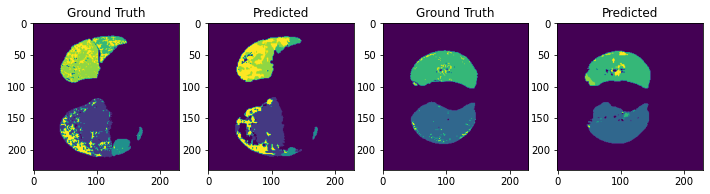

image shape: (205, 205, 219), label shape: (205, 205, 219)


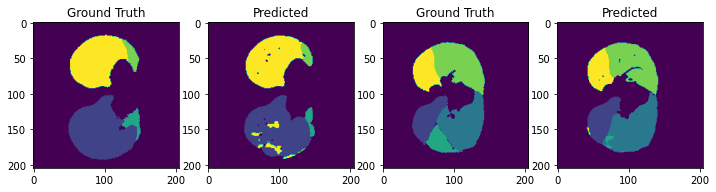

image shape: (234, 234, 237), label shape: (234, 234, 237)


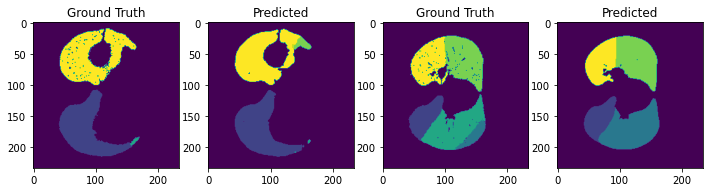

image shape: (289, 289, 203), label shape: (289, 289, 203)


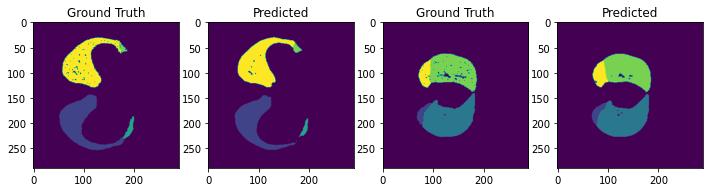

image shape: (234, 234, 237), label shape: (234, 234, 237)


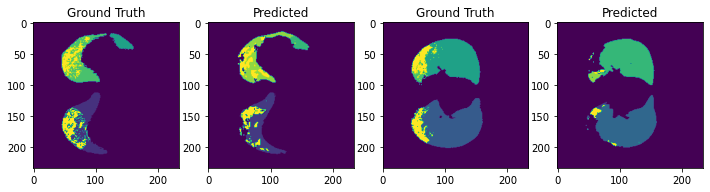

image shape: (268, 268, 225), label shape: (268, 268, 225)


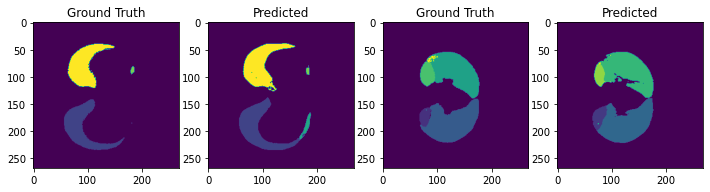

image shape: (234, 234, 201), label shape: (234, 234, 201)


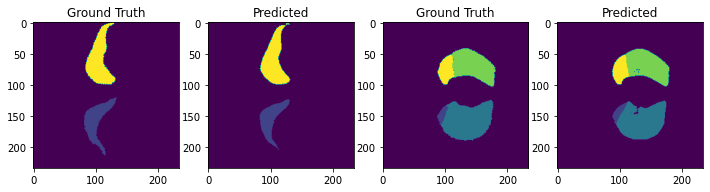

image shape: (268, 268, 225), label shape: (268, 268, 225)


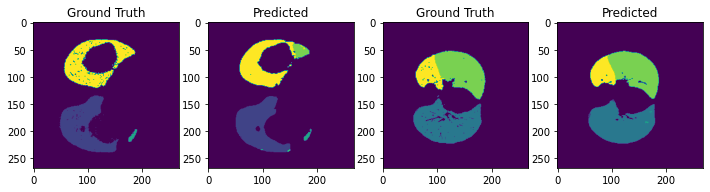

image shape: (234, 234, 194), label shape: (234, 234, 194)


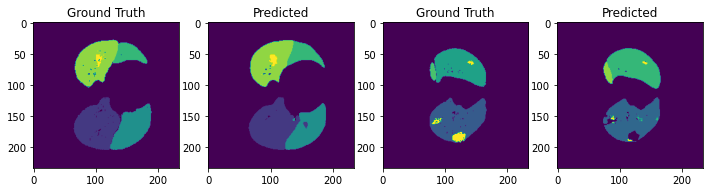

image shape: (268, 268, 225), label shape: (268, 268, 225)


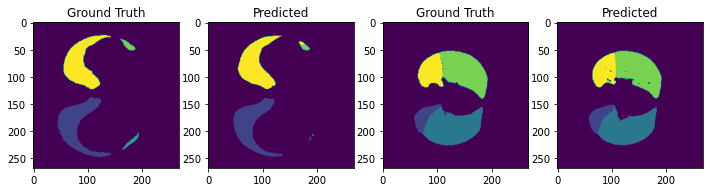

image shape: (251, 251, 196), label shape: (251, 251, 196)


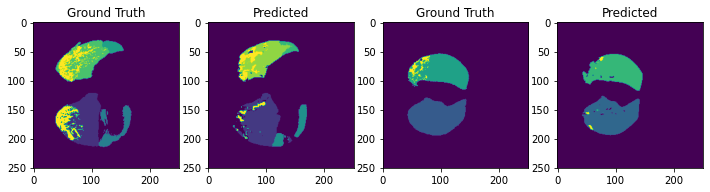

image shape: (234, 234, 194), label shape: (234, 234, 194)


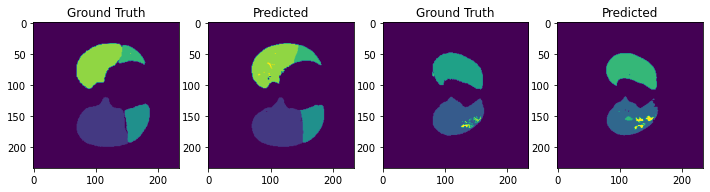

image shape: (234, 234, 237), label shape: (234, 234, 237)


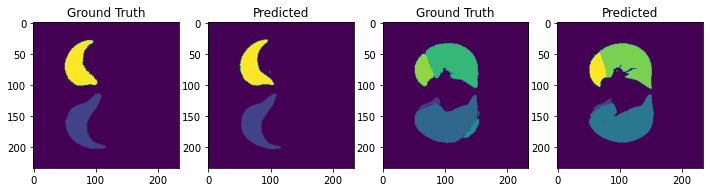

image shape: (238, 238, 224), label shape: (238, 238, 224)


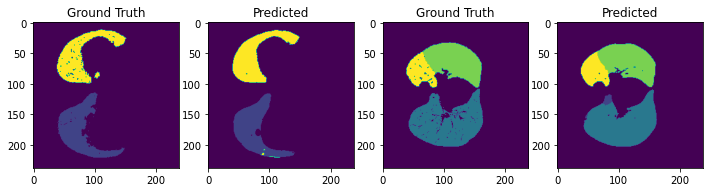

image shape: (268, 268, 225), label shape: (268, 268, 225)


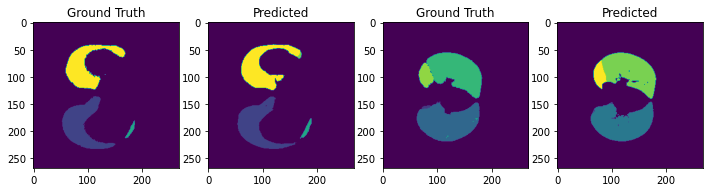

image shape: (216, 216, 224), label shape: (216, 216, 224)


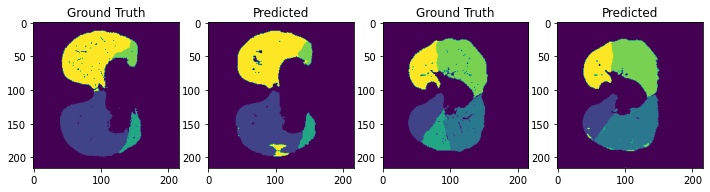

In [29]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    metric_sum = 0.0
    metric_count = 0
    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        
        mask = torch.argmax(val_outputs, dim=1).detach().cpu().numpy() 
        val_labels = val_labels.cpu().detach().numpy()   
        val_labels = np.squeeze(val_labels)
        mask = np.squeeze(mask)
        
        print(f"image shape: {val_labels.shape}, label shape: {mask.shape}")
        plt.figure('check', (12, 6))
        plt.subplot(1, 4, 1)
        plt.title('Ground Truth')
        plt.imshow(val_labels[:, :, 60])
        plt.subplot(1, 4, 2)
        plt.title('Predicted')
        plt.imshow(mask[:, :, 60])
        plt.subplot(1, 4, 3)
        plt.title('Ground Truth')
        plt.imshow(val_labels[:, :, 140])
        plt.subplot(1, 4, 4)
        plt.title('Predicted')
        plt.imshow(mask[:, :, 140])
        plt.show()